In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import chemical_category as cc
from sklearn.cross_decomposition import PLSRegression as PLS
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
# Data for test are put in 'data_test'
# Other data are available in Zenodo https://doi.org/10.5281/zenodo.8177233
df_qmex = pd.read_csv('./data_test/dataset_for_benchmark/bench_dGs_with_qmex_predict.csv')
df_cate = pd.read_csv('./data_test/dataset_for_benchmark/bench_dGs_with_category.csv')
df_idx = pd.read_csv('./data_test/idx_interp_extrap/idx_bench_dGs.csv')

In [3]:
df_feature = df_qmex.loc[:,'mw':]
df_category = df_cate.loc[:,'polar':]

# df_interaction: interaction terms for ILR
# df_pf: result of PolynomialFeatures (not used)
df_interaction, df_pf = cc.make_interaction_term(df_feature, df_category, degree=1, drop_rate=0.1, exclude_low_degree=False, is_new=False)

In [4]:
task='dGs'
Nin = 200
ex='property'
df_idx_test = df_idx[(df_idx['n_inter']==Nin)&(df_idx['extra']==ex)]
# extract each index from df_idx
idx_interp = eval(df_idx_test['idx_inter'].to_list()[0])
idx_exterp = eval(df_idx_test['idx_extra'].to_list()[0])

y_in_true = df_qmex.loc[idx_interp, [task]].values
y_ex_true = df_qmex.loc[idx_exterp, [task]].values
x_in = df_feature.loc[idx_interp].values
x_ex = df_feature.loc[idx_exterp].values
x_in_ILR = df_interaction.loc[idx_interp].values
x_ex_ILR = df_interaction.loc[idx_exterp].values

{'rmse_in': 0.235, 'rmse_ex': 3.237, 'mae_in': 0.358, 'mae_ex': 1.448, 'r2_in': 0.913, 'r2_ex': 0.894}


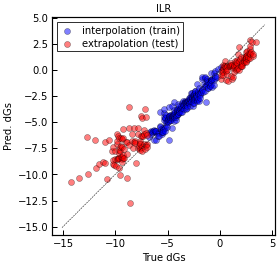

{'rmse_in': 0.3, 'rmse_ex': 3.406, 'mae_in': 0.395, 'mae_ex': 1.486, 'r2_in': 0.889, 'r2_ex': 0.888}


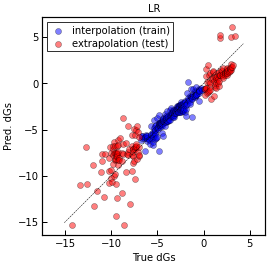

{'rmse_in': 0.052, 'rmse_ex': 11.293, 'mae_in': 0.155, 'mae_ex': 2.711, 'r2_in': 0.981, 'r2_ex': 0.629}


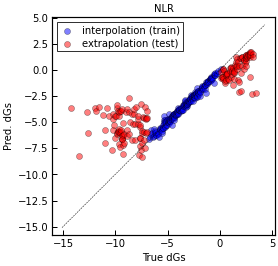

In [5]:
"""
Note that, in this code, the train is performed on the interpolated data and the test is performed on the extrapolated data for simplicity of implementation. (Interpolation results represents training result.)
On the other hand, in the benchmark, the 5-fold test was performed using the interpolated data. (Interpolation results represents 5-fold test results.)
"""
for reg in ['ILR', 'LR', 'NLR']:
  if reg=='ILR':
    model = PLS(n_components=8, scale=True, )
    model.fit(x_in_ILR, y_in_true)
    y_in_train = model.predict(x_in_ILR)
    y_ex_test = model.predict(x_ex_ILR)
  elif reg=='LR':
    model = PLS(n_components=8, scale=True, )
    model.fit(x_in, y_in_true)
    y_in_train = model.predict(x_in)
    y_ex_test = model.predict(x_ex)
  else:
    scaler_x = preprocessing.StandardScaler()
    scaler_y = preprocessing.StandardScaler()
    x_in_scaled = scaler_x.fit_transform(x_in)
    y_in_scaled = scaler_y.fit_transform(y_in_true)
    x_ex_scaled = scaler_x.transform(x_ex)

    # extract hyper-parameters from optimized result in the benckmark
    model = KRR(alpha=0.01033, gamma=0.00961, kernel='rbf')
    model.fit(x_in_scaled, y_in_scaled)
    y_in_train_scaled = model.predict(x_in_scaled)
    y_ex_test_scaled = model.predict(x_ex_scaled)
    y_in_train = scaler_y.inverse_transform(y_in_train_scaled)
    y_ex_test = scaler_y.inverse_transform(y_ex_test_scaled)

  metrics = {}
  metrics['rmse_in'] = np.round(mean_squared_error(y_in_true, y_in_train),3)
  metrics['rmse_ex'] = np.round(mean_squared_error(y_ex_true, y_ex_test),3)
  metrics['mae_in'] = np.round(mean_absolute_error(y_in_true, y_in_train),3)
  metrics['mae_ex'] = np.round(mean_absolute_error(y_ex_true, y_ex_test),3)
  metrics['r2_in'] = np.round(r2_score(y_in_true, y_in_train),3)
  metrics['r2_ex'] = np.round(r2_score(y_ex_true, y_ex_test),3)

  print(metrics)

  # plot
  fig = plt.figure(figsize=(4,4))
  ax = plt.subplot()
  ax.scatter(y_in_true, y_in_train, c='b', ec='k', lw=0.5, alpha=0.5, label='interpolation (train)')
  ax.scatter(y_ex_true, y_ex_test, c='r', ec='k', lw=0.5, alpha=0.5, label='extrapolation (test)')
  ax.plot([*ax.get_xlim()], [*ax.get_xlim()], c='k', lw=0.5, ls='--')
  ax.legend()
  ax.set_xlabel(f'True {task}')
  ax.set_ylabel(f'Pred. {task}')
  ax.axis('square')
  ax.axis('equal')
  ax.set_title(reg)
  plt.show()
  plt.close()